# (17) emnist — conv

**Motivation**: host = ```mach```, device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
# sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_quick
from figures.analysis import plot_convergence
from figures.imgs import plot_weights

device_idx = 0
device = f'cuda:{device_idx}'

print(f"device: {device}  ———  host: {os.uname().nodename}")

device: cuda:0  ———  host: mach

## MNIST:

- amortized, iterative, ```<conv|conv>```
- k = 128
- dec starting spat_dim = 2
- $(T, \beta) = (16, 6.0)$

### Get configs

In [3]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('EMNIST', model_type, 'conv|conv')

seq_len = 16
cfg_vae['track_stats'] = True
cfg_vae['seq_len'] = seq_len
cfg_vae['n_latents'] = 128

cfg_tr['kl_beta'] = 3/8 * seq_len

### Make model + trainer

In [4]:
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

In [5]:
tr.n_iters

124800

### Print info

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|    IPVAE    |  3.1 Mil   |
|     ———     |    ———     |
|    layer    |  3.1 Mil   |
+-------------+------------+

poisson_EMNIST_t-16_z-[128]_k-32_<conv|conv>
b200-ep200-lr(0.002)_beta(6:0x0.1)_temp(0.05:lin-0.5)_gr(150)_(2024_09_19,10:27)

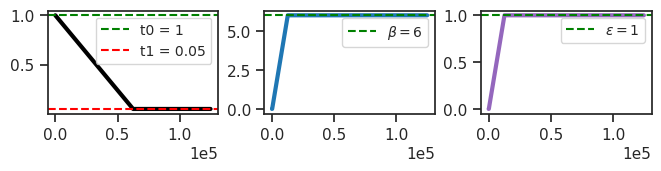

In [6]:
vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [7]:
tr.n_iters

124800

In [8]:
print_num_params(tr.model.layer)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
| PoissonLayer |  3.1 Mil   |
|     ———      |    ———     |
|     stem     |    320     |
|     enc      |  1.2 Mil   |
|    fc_enc    |  524.4 K   |
|    fc_dec    |  132.1 K   |
|     dec      |  1.2 Mil   |
+--------------+------------+

### Fit model

In [9]:
tr.train()

epoch # 200, avg loss: 9.805270: 100%|████| 200/200 [12:03:29<00:00, 217.05s/it]


In [9]:
## Was: MNIST iterative

epoch # 400, avg loss: 11.754415: 100%|███| 400/400 [22:03:10<00:00, 198.48s/it]


In [14]:
u_max = np.array(tr.model.stats['u_max'])
du_max = np.array(tr.model.stats['du_max'])

u_max.max(), du_max.max()

(7.999087810516357, 7.0)

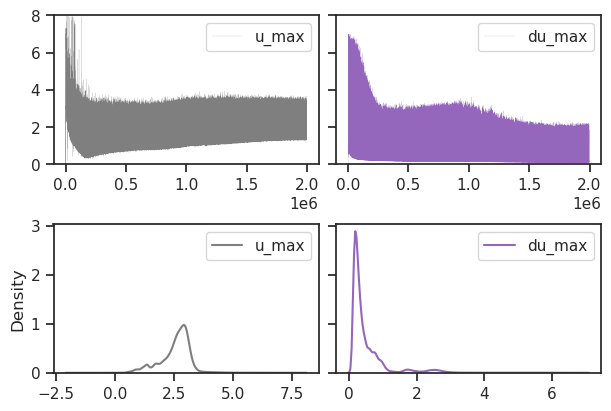

In [15]:
fig, axes = create_figure(2, 2, sharey='row')

axes[0, 0].plot(u_max, color='C7', lw=0.1, label='u_max')
axes[0, 1].plot(du_max, color='C4', lw=0.1, label='du_max')
axes[0, 1].set(ylim=(0, 8))

sns.kdeplot(u_max, color='C7', label='u_max', ax=axes[1, 0])
sns.kdeplot(du_max, color='C4', label='du_max', ax=axes[1, 1])

add_legend(axes)
plt.show()

In [16]:
grad = np.array(list(tr.stats['grad'].values()))
(grad > tr.cfg.grad_clip).sum(), np.round((grad > tr.cfg.grad_clip).mean(), 3)

(1917, 0.015)

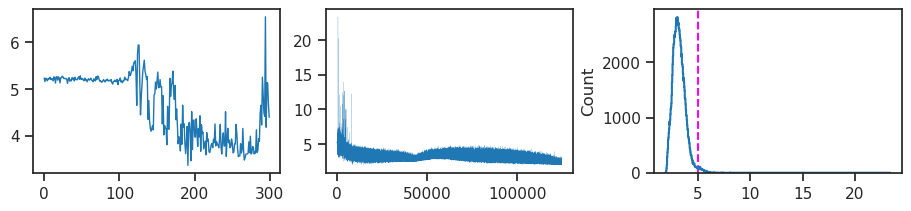

In [17]:
fig, axes = create_figure(1, 3)

axes[0].plot(np.log(grad)[:300], lw=1)
axes[1].plot(np.log(grad), lw=0.1)

axes[2].axvline(np.log(tr.cfg.grad_clip), color='magenta', ls='--')
histplot(np.log(grad), ax=axes[2])

plt.show()

### Load model

In [11]:
# model_name = 'poisson_uniform_c(-2)_MNIST_t-8_z-[32]_k-32_<jacob|conv+b>'
# fit_name = 'b200-ep500-lr(0.002)_beta(8:0x0.5)_temp(0.05:lin-0.5)_gr(1000)_(2024_09_06,23:11)'
# tr, meta = load_model(model_name, fit_name, device=device)
# meta['checkpoint']

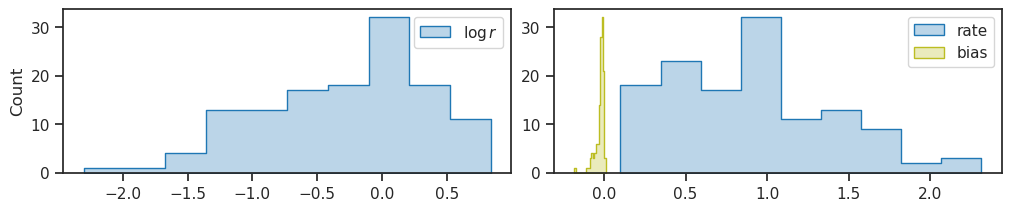

In [18]:
log_rate = tonp(tr.model.layer.log_rate).ravel()
bias = tonp(tr.model.layer.bias).ravel()

fig, axes = create_figure(1, 2, (10, 2))
kws = dict(fill=True, lw=1, alpha=0.3, ax=axes[0])
sns.histplot(log_rate, color='C0', element='step', label=r'$\log r$', **kws)

kws = dict(fill=True, lw=1, alpha=0.3, ax=axes[1])
sns.histplot(np.exp(log_rate), color='C0', element='step', label='rate', **kws)
sns.histplot(bias, color='C8', element='step', label='bias', **kws)

axes[1].set(ylabel='')
add_legend(axes)

plt.show()

In [19]:
dead = log_rate > 2
dead.sum(), (~dead).sum(), dead.sum() / len(dead)

(0, 128, 0.0)

100%|███████████████████████████████| 104/104 [15:08<00:00,  8.74s/it]


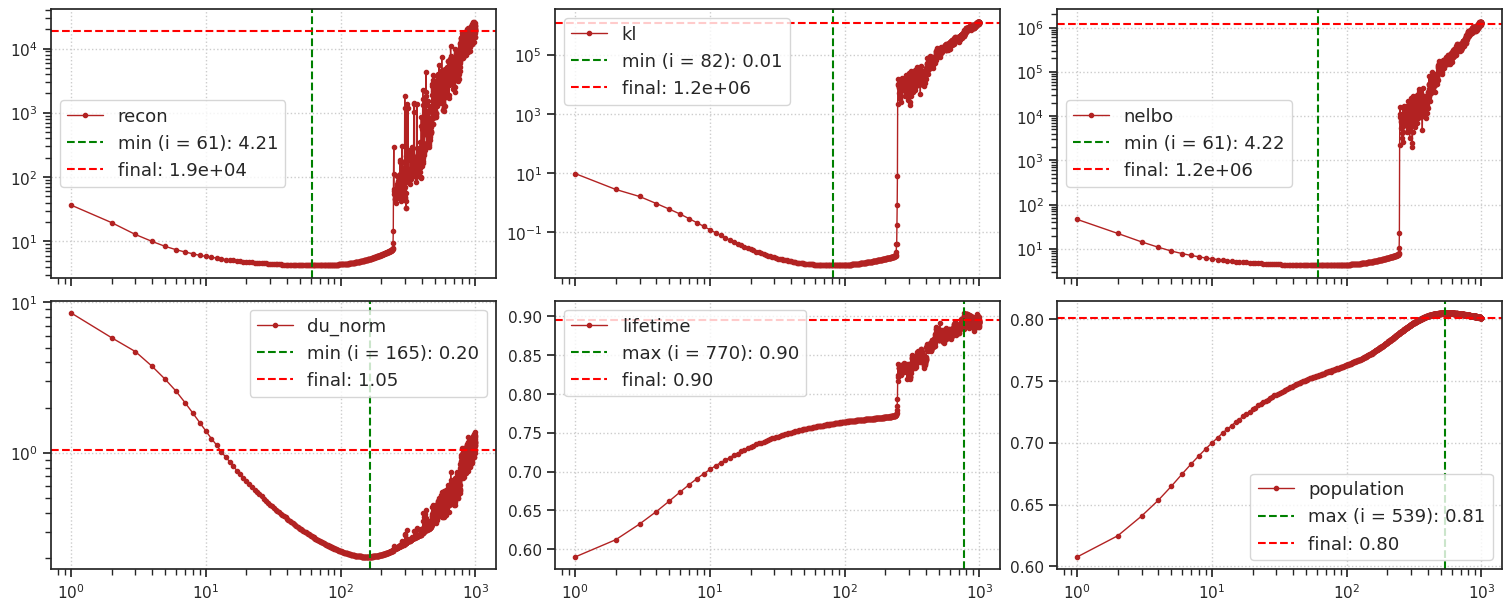

CPU times: user 15min 10s, sys: 2.71 s, total: 15min 13s
Wall time: 15min 13s


In [31]:
%%time

kws = dict(
    seq_total=1000,
    seq_batch_sz=100,
    n_data_batches=None,
    # active=~dead,
)
results = tr.analysis(dl='vld', **kws)
_ = plot_convergence(results, color='firebrick')

100%|██████████████████████████████| 50/50 [3:34:56<00:00, 257.93s/it]


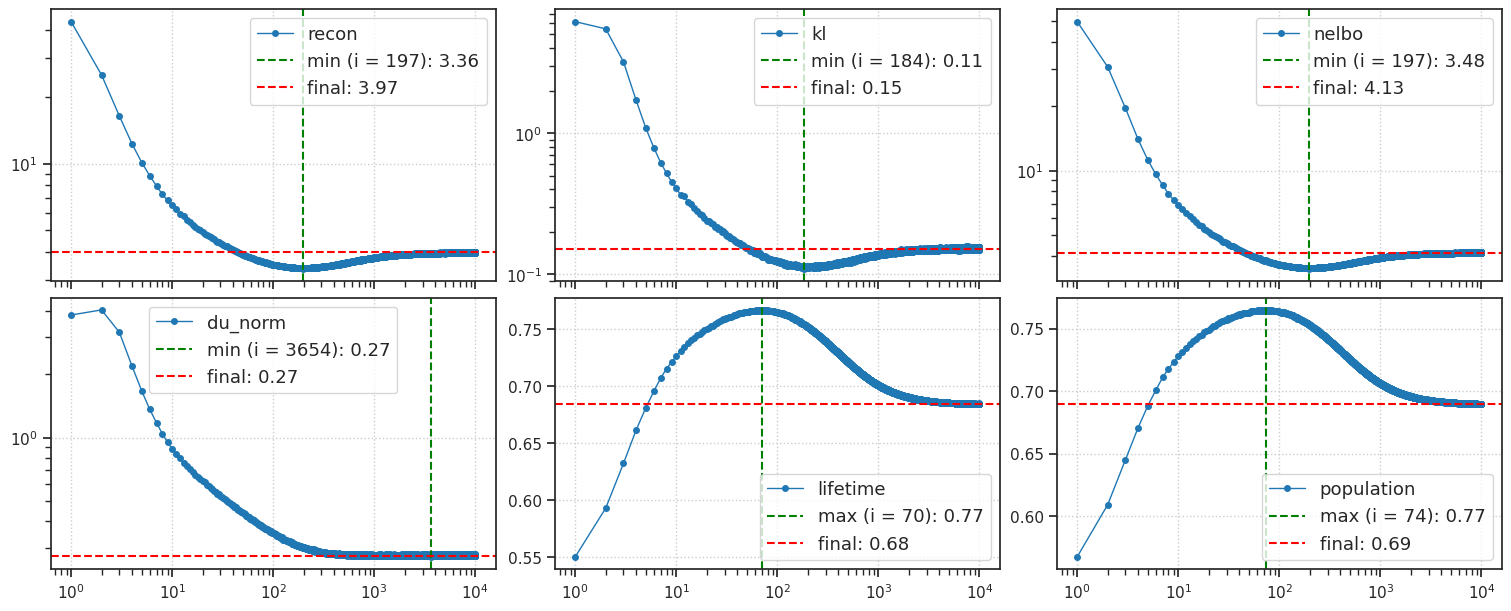

CPU times: user 3h 33min 4s, sys: 1min 14s, total: 3h 34min 18s
Wall time: 3h 35min 16s


In [21]:
## Was: <jacob|conv>

In [21]:
kws = dict(
    seq_total=tr.model.cfg.seq_len,
    seq_batch_sz=100,
    n_data_batches=1,
    # active=~dead,
    return_recon=True,
    full_data=True,
    verbose=False,
)
results_to_plot = {
    name: tr.analysis(dl=name, **kws)
    for name in ['trn', 'vld']
}

trn

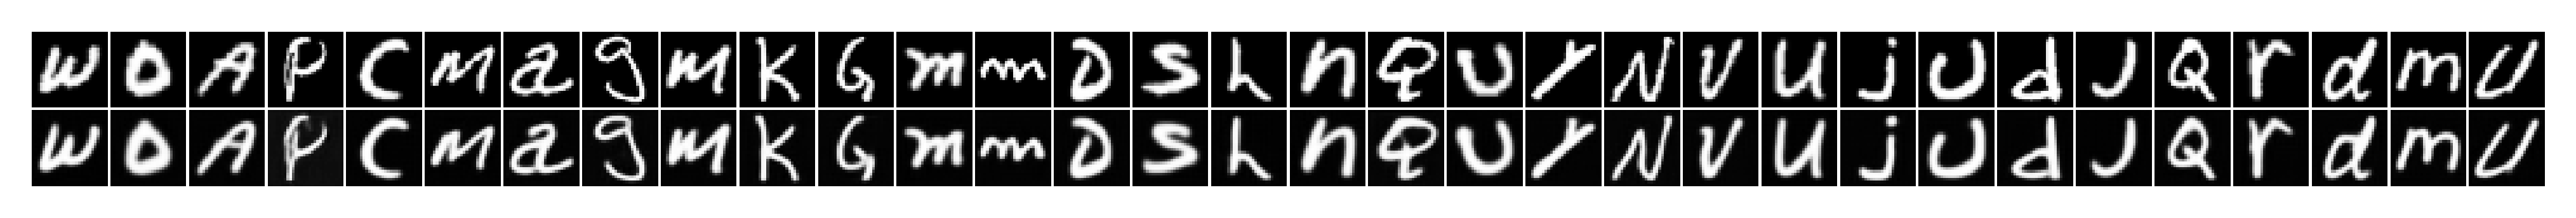

vld

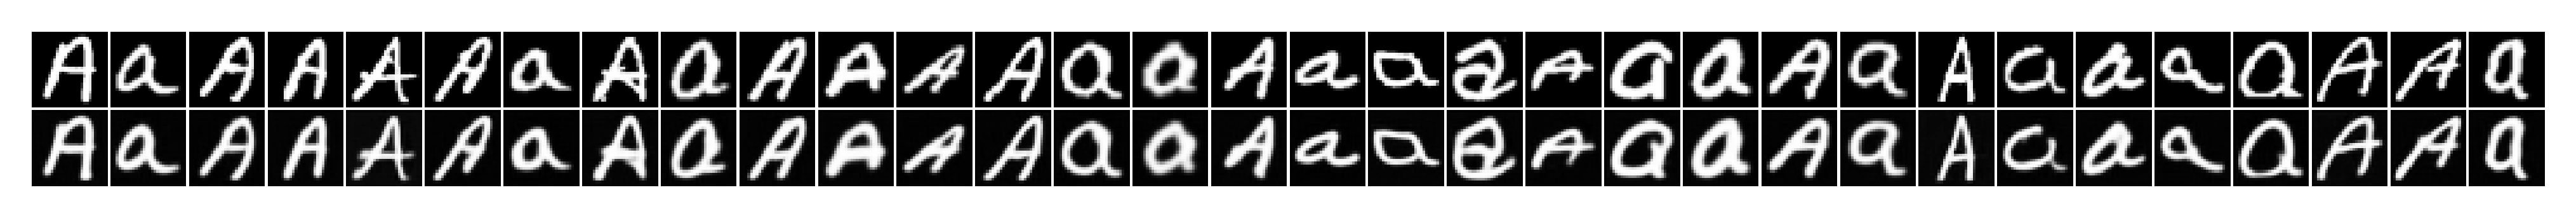

In [29]:
num = 32

inds = np.random.choice(200, num, replace=False)

for name, d in results_to_plot.items():
    print(name)
    x2p = np.concatenate([
        d['x'][inds],
        d['y'][inds, -1].reshape(-1, *tr.model.cfg.input_sz),
    ])
    _ = plot_weights(x2p, nrows=2, dpi=500)

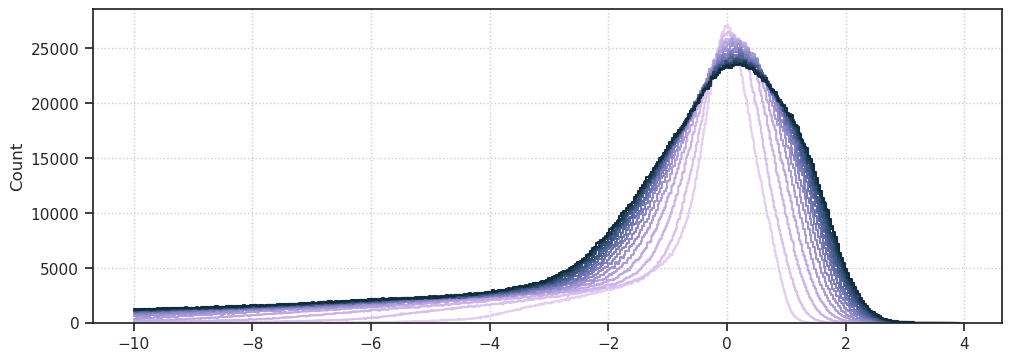

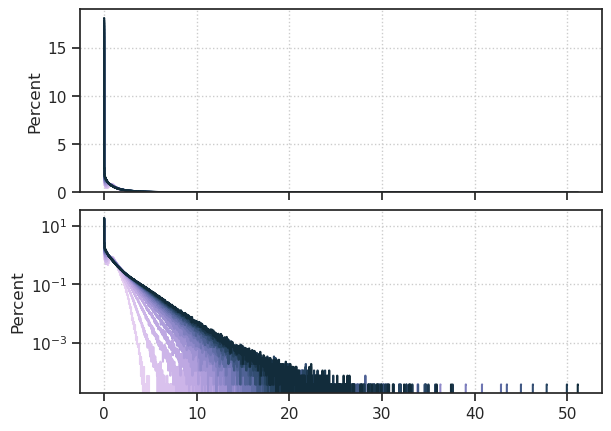

In [30]:
posterior_log_rates = collections.defaultdict(list)
for x, *_ in iter(tr.dl_vld):
    output = tr.model.xtract_ftr(x)
    for t, pois in output['dist'].items():
        posterior_log_rates[t].append(torch.log(pois.rate))
posterior_log_rates = {
    t: tonp(torch.cat(v)) for t, v
    in posterior_log_rates.items()
}


fig, ax = create_figure(1, 1, (10, 3.5))
pal = get_cubehelix_palette(tr.model.cfg.seq_len, start=2.5)

for i, (t, v) in enumerate(posterior_log_rates.items()):
    x2p = v[:, ~dead].ravel()
    x2p = x2p[x2p > -10]
    histplot(
        x2p,
        fill=False,
        color=pal[i],
        label=f"T = {t}",
        ax=ax,
    )
# ax.legend()
ax.grid()
plt.show()


fig, axes = create_figure(2, 1, (6, 4.2), sharex='col')
for i, (t, v) in enumerate(posterior_log_rates.items()):
    for ax in axes.flat:
        sns.histplot(
            np.exp(v[:, ~dead].ravel()),
            stat='percent',
            element='step',
            fill=False,
            color=pal[i],
            label=f"T = {t}",
            ax=ax,
        )
axes[1].set(yscale='log')
add_grid(axes)
plt.show()